# Mean Curvature Flow (revisited)

[As discussed before](mcf_nb.ipynb)
we can simulate the shrinking of a sphere under mean curvature flow
using a finite element approach based on
the following time discrete approximation:
\begin{align}
\int_{\Gamma^n} \big( U^{n+1} - {\rm id}\big) \cdot \varphi +
\tau \int_{\Gamma^n} \big(
\theta\nabla_{\Gamma^n} U^{n+1} + (1-\theta) I \big)
\colon\nabla_{\Gamma^n}\varphi
=0~.
\end{align}
Here $U^n$ parametrizes $\Gamma(t^{n+1})$ over
$\Gamma^n:=\Gamma(t^{n})$,
$I$ is the identity matrix, $\tau$ is the time step and
$\theta\in[0,1]$ is a discretization parameter.

If the initial surface $\Gamma^0$ is a sphere of radius $R_0$,
the surface remains sphere and we have an exact formula for the evolution
of the radius of the surface

$$R(t) = \sqrt{R_0^2 - 4t}.$$

To compare the accuracy of the surface approximation we compute an
average radius of the discrete surface in each time step $t^n$ using

$$R_h^n = \frac{ \int_{\Gamma^n} |x| }{ |\Gamma^n| }.$$

Computing $R_h^n$ requires a grid traversal and a number of calls to
interface methods on each element. Doing this on the Python side has a
potential performance impact which we investigate here by comparing a
pure python implementation with a hybrid approach where computing $R_h^n$
is implemented in C++ using the `dune.generator.algorithm` functionality.

In [1]:
import time, io
import pickle
import numpy
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter

from ufl import *
import dune.ufl
from dune.generator import algorithm
import dune.geometry as geometry
import dune.fem as fem

def plot(ct, ct2):
    fig, ax = plt.subplots()
    plt.loglog(ct[0][:], ct[1][:],'*-', markersize=15, label='hybrid')
    plt.loglog(ct2[0][:], ct2[1][:],'*-', markersize=15, label='python')
    plt.grid(True)
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_major_formatter(ScalarFormatter())
        axis.set_minor_formatter(ScalarFormatter())
    yticks = ax.yaxis.get_minor_ticks()
    for t in yticks:
        t.label1.set_visible(False)
    xticks = ax.xaxis.get_minor_ticks()
    for t in xticks:
        t.label1.set_visible(False)
    plt.yticks(numpy.append(ct[1], ct2[1]))
    plt.xticks(ct[0])
    plt.legend(loc="upper left")
    plt.xlabel('Number of Grid Elements (log)',fontsize=20)
    plt.gcf().subplots_adjust(bottom=0.17, left=0.16)
    plt.ylabel('Runtime in s (log)',fontsize=20)

# polynomial order of surface approximation
order = 2

# initial radius
R0 = 2.

# end time
endTime = 0.1

Main function for calculating the mean curvature flow of a given surface.
If first argument is `True` the radius of the computed surface is
computed using an algorithm implemented in C++ otherwise the computation
is done in Python.

In [2]:
def calcRadius(surface):
    R,vol = 0, 0
    for e in surface.elements:
        rule = geometry.quadratureRule(e.type, 4)
        for p in rule:
            geo = e.geometry
            weight = geo.volume * p.weight
            R   += geo.toGlobal(p.position).two_norm * weight
            vol += weight
    return R/vol

code = """
#include <dune/geometry/quadraturerules.hh>
template< class Surface >
double calcRadius( const Surface &surface ) {
  double R = 0, vol = 0.;
  for( const auto &entity : elements( surface ) ) {
    const auto& rule = Dune::QuadratureRules<double, 2>::rule(entity.type(), 4);
    for ( const auto &p : rule ) {
      const auto geo = entity.geometry();
      const double weight = geo.volume() * p.weight();
      R   += geo.global(p.position()).two_norm() * weight;
      vol += weight;
    }
  }
  return R/vol;
}
"""
switchCalcRadius = lambda use_cpp,surface: \
             algorithm.load('calcRadius', io.StringIO(code), surface) \
             if use_cpp else calcRadius

Timings for a number of different grid refinements is dumped to disk

In [3]:
from dune.fem.view import geometryGridView as geoGridView
from dune.fem.space import lagrange as solutionSpace
from dune.fem.scheme import galerkin as solutionScheme
def calculate(use_cpp, gridView):
    # space on Gamma_0 to describe position of Gamma(t)
    space = solutionSpace(gridView, dimRange=gridView.dimWorld, order=order)
    u = TrialFunction(space)
    v = TestFunction(space)
    x = SpatialCoordinate(space.cell())
    positions = space.interpolate(x, name="position")

    # space for discrete solution on Gamma(t)
    surface = geoGridView(positions)
    space = solutionSpace(surface, dimRange=surface.dimWorld, order=order)
    solution  = space.interpolate(x, name="solution")

    # set up model using theta scheme
    theta = 0.5   # Crank-Nicolson

    I = Identity(3)
    dt = dune.ufl.Constant(0,"dt")

    a = (inner(u - x, v) + dt * inner(theta*grad(u)
        + (1 - theta)*I, grad(v))) * dx

    scheme = solutionScheme(a == 0, space, solver="cg")

    Rexact = lambda t: numpy.sqrt(R0*R0 - 4.*t)
    radius = switchCalcRadius(use_cpp,surface)

    dt.value = 0.02

    numberOfLoops = 3
    times = numpy.zeros(numberOfLoops)
    errors = numpy.zeros(numberOfLoops)
    totalIterations = numpy.zeros(numberOfLoops, numpy.dtype(numpy.uint32))
    gridSizes = numpy.zeros(numberOfLoops, numpy.dtype(numpy.uint32))
    for i in range(numberOfLoops):
        positions.interpolate(x * (R0/sqrt(dot(x,x))))
        solution.interpolate(x)
        t = 0.
        error = abs(radius(surface)-Rexact(t))
        iterations = 0
        start = time.time()
        while t < endTime:
            info = scheme.solve(target=solution)
            # move the surface
            positions.assign(solution)
            # store some information about the solution process
            iterations += int( info["linear_iterations"] )
            t          += scheme.model.dt
            error       = max(error, abs(radius(surface)-Rexact(t)))
        print("time used:", time.time() - start)
        times[i] = time.time() - start
        errors[i] = error
        totalIterations[i] = iterations
        gridSizes[i] = gridView.size(2)
        if i < numberOfLoops - 1:
            gridView.hierarchicalGrid.globalRefine(1)
            dt.value /= 2
    eocs = numpy.log(errors[0:][:numberOfLoops-1] / errors[1:]) / numpy.log(numpy.sqrt(2))
    try:
        import pandas as pd
        keys = {'size': gridSizes, 'error': errors, "eoc": numpy.insert(eocs, 0, None), 'iterations': totalIterations}
        table = pd.DataFrame(keys, index=range(numberOfLoops),columns=['size', 'error', 'eoc', 'iterations'])
        print(table)
    except ImportError:
        print("pandas module not found so not showing table - ignored")
        pass
    return gridSizes, times

Compute the mean curvature flow evolution of a spherical surface. Compare
computational time of a pure Python implementation and using a C++
algorithm to compute the radius of the surface for verifying the
algorithm.

In [4]:
# set up reference domain Gamma_0
results = []
from dune.alugrid import aluConformGrid as leafGridView
gridView = leafGridView("sphere.dgf", dimgrid=2, dimworld=3)
results += [calculate(True, gridView)]

gridView = leafGridView("sphere.dgf", dimgrid=2, dimworld=3)
results += [calculate(False, gridView)]

time used: 0.44835877418518066


time used: 2.581859827041626


time used: 10.766730546951294


   size     error       eoc  iterations
0   318  0.001060       NaN          76
1   766  0.000605  1.619153         208
2  1745  0.000275  2.275142         420


time used: 0.6182475090026855


time used: 3.3623735904693604


time used: 14.045575857162476
   size     error       eoc  iterations
0   318  0.001060       NaN          76
1   766  0.000605  1.619153         208
2  1745  0.000275  2.275142         420


Compare the hybrid and pure Python versions

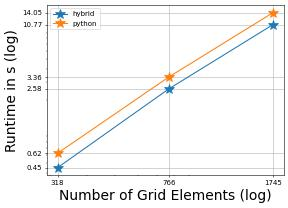

In [5]:
plot(results[0],results[1])